# Importing usefull libraries,scripts and downloading the data

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
sys.path.append('..')
import warnings

warnings.filterwarnings('ignore')

from scripts import dataframe as dfr

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
!wget $data

--2022-10-26 11:20:50--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K   512KB/s    in 0.3s    

2022-10-26 11:20:51 (512 KB/s) - ‘CreditScoring.csv’ saved [182489/182489]



# Data cleaning and preparation

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [5]:
df = dfr.data_frame_refining(df)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [7]:
status_values = {
    1:'ok',
    2:'default',
    0:'unk'
}
df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [11]:
for col in ['income','assets','debt']:
    df[col] = df[col].replace(to_replace=99999999,value=np.nan)

In [12]:
df.describe()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.000000,4455.000000,4455.000000,4455.000000,4421.000000,4408.000000,4437.000000,4455.000000,4455.000000
mean,7.987205,46.441751,37.077666,55.568799,130.568197,5403.433984,342.948614,1039.021773,1462.875645
std,8.173444,14.655225,10.984856,19.515878,86.367434,11573.161523,1245.861736,474.543007,628.089913
min,0.000000,6.000000,18.000000,35.000000,0.000000,0.000000,0.000000,100.000000,105.000000
25%,2.000000,36.000000,28.000000,35.000000,80.000000,0.000000,0.000000,700.000000,1117.500000
50%,5.000000,48.000000,36.000000,51.000000,120.000000,3000.000000,0.000000,1000.000000,1400.000000
75%,12.000000,60.000000,45.000000,72.000000,165.000000,6000.000000,0.000000,1300.000000,1692.000000
max,48.000000,72.000000,68.000000,180.000000,959.000000,300000.000000,30000.000000,5000.000000,11140.000000


In [13]:
df = df.fillna(0)

In [14]:
df.isna().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [15]:
df = df[df.status!='unk'].reset_index(drop=True)

In [16]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=11)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status=='default').astype('int').values
y_val = (df_val.status=='default').astype('int').values
y_test = (df_test.status=='default').astype('int').values

del df_train['status']
del df_val['status']
del df_test['status']

# Decision Trees

In [17]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'permanent':
            return 'default'
        else: 
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'


In [18]:
assess_risk(df_train.iloc[0].to_dict())

'ok'

In [19]:
df_train.iloc[0].to_dict()

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [20]:
train_dict = df_train.to_dict(orient='records')

In [21]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [23]:
val_dict = df_val.to_dict(orient='records')
x_val = dv.transform(val_dict)

In [24]:
y_pred = dt.predict_proba(x_val)[:,1]

In [25]:
roc_auc_score(y_val,y_pred)

0.6676606282240682

In [26]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

1.0

In [27]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [28]:
y_pred = dt.predict_proba(x_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7389079944782155

In [29]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

0.7761016984958594

In [30]:
print(export_text(dt,feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



# Decision tree learning algorithm

In [32]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

In [34]:
df_eg = pd.DataFrame(data,columns=['assets','status'])
df_eg

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [36]:
df_eg.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [37]:
Ts = [0,2000,3000,4000,5000,8000]

In [44]:
T = 4000

df_left = df_eg[df_eg.assets<=T]
df_right = df_eg[df_eg.assets>T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64


In [55]:
for T in Ts:
    print(f'For a threshold of {T}')

    df_left = df_eg[df_eg.assets<=T]
    df_right = df_eg[df_eg.assets>T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print('\n####################\n')

For a threshold of 0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

####################

For a threshold of 2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

####################

For a threshold of 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

####################

For a threshold of 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

####################

For a threshold of 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

####################

For a threshold of 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64

####################



In [56]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

In [57]:
df_eg = pd.DataFrame(data,columns=['assets','debt','status'])
df_eg

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [58]:
df_eg.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [59]:
thresholds = {
    'assets': [0,2000,3000,4000,5000,8000],
    'debt': [500,1000,2000]
}

In [64]:
for feature,Ts in thresholds.items():
    print('\n***************************\n')
    print(f'For the feature {feature}')
    for T in Ts:

        print (f'\nFor the threshold of {T}')

        df_left = df_eg[df_eg.assets<=T]
        df_right = df_eg[df_eg.assets>T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        print('\n####################\n')
    print('\n***************************\n')


***************************

For the feature assets

For the threshold of 0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

####################


For the threshold of 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

####################


For the threshold of 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

####################


For the threshold of 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

####################


For the threshold of 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

####################


For the threshold of 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

####################


***************************


***************************

For the feature debt

For the threshold of 500


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

####################


For the threshold of 1000


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

####################


For the threshold of 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

####################


***************************



# Decision Tree paramater tunning

In [70]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train,y_train)

    y_pred = dt.predict_proba(x_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)

    print('%5s -> %.3f'%(depth,auc))

    1 -> 0.606
    2 -> 0.669
    3 -> 0.739
    4 -> 0.761
    5 -> 0.767
    6 -> 0.752
   10 -> 0.704
   15 -> 0.675
   20 -> 0.659
 None -> 0.656


In [71]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:

        dt = DecisionTreeClassifier(max_depth=depth,min_samples_leaf=s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(x_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)

        scores.append((depth,s,auc))

In [76]:
columns = ['depth','min_sample_leaf','auc']

df_scores = pd.DataFrame(scores,columns=columns)
df_scores.shape
df_scores.head()

,depth,min_sample_leaf,auc
0,4,1,0.761283
1,4,5,0.761283
2,4,10,0.761283
3,4,15,0.763726
4,4,20,0.760910


In [78]:
df_scores.sort_values('auc',ascending=False)

,depth,min_sample_leaf,auc
19,6,15,0.785250
18,6,10,0.777521
22,6,100,0.776434
20,6,20,0.774279
12,5,20,0.773537
11,5,15,0.772723
23,6,200,0.768267
9,5,5,0.767755
8,5,1,0.766496
3,4,15,0.763726


In [81]:
df_scores_pivot = df_scores.pivot(index = 'min_sample_leaf',columns = ['depth'],values=['auc'])
df_scores_pivot.round(3)

auc              
depth                4      5      6
min_sample_leaf                     
1                0.761  0.766  0.750
5                0.761  0.768  0.762
10               0.761  0.762  0.778
15               0.764  0.773  0.785
20               0.761  0.774  0.774
100              0.756  0.763  0.776
200              0.747  0.759  0.768
500              0.680  0.680  0.680

<AxesSubplot: xlabel='None-depth', ylabel='min_sample_leaf'>

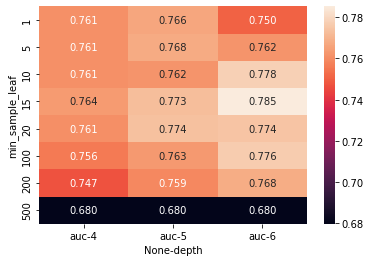

In [84]:
sns.heatmap(df_scores_pivot,fmt='.3f',annot=True)

In [85]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=15)
dt.fit(X_train,y_train)

print(export_text(dt,feature_names=dv.get_feature_names()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

# Ensembles and Random Forest

In [86]:
print('Doing cool staffs')

Doing cool staffs
